$$\require{mhchem}$$
# Monod-type denitrification model

In this notebook I use the Monod equations proposed by Störiko et al. 2021 and 2022.

Reactions (Störiko et al 2021):

1. *denitrification 1*: $\ce{7NO3- + C4H6O4 ->[nar] 7NO2- + 4CO2 + 3H2O}$
2. *denitrificantion 2*: $\ce{14NO2- + 14H+ + 3C4H6O4 ->[nir] 7N2 + 12CO2 + 16H2O}$
3. *aerobic respiration*: $\ce{7O2 + 2C4H6O4 -> 7NO2- + 8CO2 + 6H2O}$
---------------
In this model, denitrification rates are described by a Monod term:

$r_{j} = \nu_{max}^i B \frac{C_{j}}{C_{j} + K_{j}} \frac{I_{reac}^i}{I_{reac}^i + C_{O2}} $

for $j \in (nar, nir)$

the aerobic respiration is also described by another monod term:

$r_{\ce{O2}} = \nu_{\ce{O2}}^i B \frac{C_{\ce{O2}}}{C_{\ce{O2}} + K_{\ce{O2}}} \frac{C_{\ce{DOC}}}{C_{\ce{DOC}} + K_{\ce{DOC}}} $  

--------------------
DOC consumption is modelled by adding the stoichiometric corrected rates from the denitrification and aerobic oxidation rates:

$r_{\ce{DOC}}^{j} = \frac{\gamma_{\ce{DOC}}^{j}}{\gamma_{\ce{A}}^{j}}*r_{j}$

for $j \in (nar, nir, \ce{O2})$

and the full rate is defined by the expression:

$r_{DOC} = \sum_j r_{DOC}^j$

DOC release from the sediment contained POC is modelled with the expression:

$r_{rel} = k_{rel}^{DOC}*(C_{DOC}^{sat}- C_{DOC}) $

The final expression for change in $\ce{DOC}$ is then:

$\frac{d[DOC]}{dt} = r_{rel} - r_{DOC} $

---------------------

Bacterial growth is represented by the following reaction:

$\ce{3C4H6O4 + 2NH4+ -> C10H18O5N2 + 2CO2 + 3H2O + 2H+}$

$\ce{NH4+}$ is assumed non limiting. Thus biological growth is modelled with the following expression:

$r_{growth}^{i} = Y_i*r_{DOC}^i$ 

And the specific yield of each consumption reaction is modelled by a logistic function assuming a maximum bacterial growth:

$Y_i = Y_{i,max}*\left(1-\frac{B}{B_{max}}\right)$

Bacterial decay modelled with first order rate:

$r_{dec} = k_{dec}*B$

The final expression for bacterial density change is:

$ \frac{dB}{dt} = \sum_i r_{growth}^{i} - r_{dec}$

but we begin with just the O2 model

#### importing libraries

In [1]:
import os
import numpy as np
import scipy
#import sunode
import matplotlib.pyplot as plt

In [2]:
import sys
sys.executable

'/home/vcantarella/miniconda3/envs/nit-env/bin/python'

In [3]:
# again, this only works on startup!
from jax.config import config
config.update("jax_enable_x64", True)

### Define the Model

The model we use the is an implicit model in time and discretized in space that solved internally with an ODE solver from scipy (odeint).
To run the model, first we must define the parameters.

In [4]:
import sys
sys.path.append('../../')

In [5]:
from src.models.general_implicit_ade import ColumnModel

In [6]:
model = ColumnModel({0: 'DOC',1: 'Oxygen',2: 'Bacteria'}, np.array([1,1,0]))

#### transport parameters

In [7]:
model.add_transport_parameters(velocity = 5e-6, longitudinal_dispersivity = 7e-2, diffusion_coefficient = 3e-9)

#### Estimate a grid

We define the grid based on our transport parameters, so solution is accurate and stable (Peclet Number < 1).

In [8]:
length = 0.5 #m

In [9]:
mixf = (7e-2*1e-7+3e-9)
#Max x size (Peclet number = 0.1)
max_deltax = 0.1*mixf/1e-7
print(max_deltax)
x_steps_min = length/max_deltax
x_steps_min = np.ceil(x_steps_min)
print(x_steps_min)

0.01
50.0


In [10]:
deltax = 0.005
x_steps = length/deltax

In [11]:
model.add_grid(length, ncells = np.int64(x_steps), deltax = deltax)

### Kinetic reactions

#### O2 oxidation of DOC



aerobic respiration is also described by another monod term:

$r_{\ce{O2}} = \nu_{\ce{O2}}^i B \frac{C_{\ce{O2}}}{C_{\ce{O2}} + K_{\ce{O2}}} \frac{C_{\ce{DOC}}}{C_{\ce{DOC}} + K_{\ce{DOC}}} $

In [12]:
def o2_oxydation(y, parameters):
    max_rate = parameters[0]
    half_o2 = parameters[1]
    half_doc = parameters[2]
    phi = parameters[3]
    rho_s = parameters[4]
    r = max_rate*y[:,2]*((1-phi)/phi)*(y[:,0]/(y[:,0]+half_o2))*(y[:,1]/(y[:,1]+half_doc))
    return - r

* DOC consumption is just the stoichiometrically corrected rate of o2 consumption:

$r_{DOC} = \frac{\gamma_{\ce{DOC}}}{\gamma_{\ce{O2}}}*r_{\ce{O2}}$

In [13]:
def doc_consumption(y, parameters):
    return (2/7)*o2_oxydation(y, parameters)

Bacteria growth is modelled by the Yield defined by max rate and max carrying capacity:

$r_{growth}^{i} = Y_i*r_{DOC}^i$ 

And the specific yield of each consumption reaction is modelled by a logistic function assuming a maximum bacterial growth:

$Y_i = Y_{i,max}*\left(1-\frac{B}{B_{max}}\right)$

Bacterial decay modelled with first order rate:

$r_{dec} = k_{dec}*B$

The final expression for bacterial density change is:

$ \frac{dB}{dt} = \sum_i r_{growth}^{i} - r_{dec}$

In [14]:
def bacteria_rate(y, parameters):
    Y_max = parameters[5]
    B_max = parameters[6]
    k_dec = parameters[7]
    Y = Y_max*(1-y[:,2]/B_max)
    growth = (2/7)*(-1)*o2_oxydation(y, parameters)*Y
    decay = k_dec*y[:,2]
    return growth - decay

Add them to the model

In [15]:
parameters = (6.41e-19, #mol/cells
              31e-6, #mol O2/L
              40e-6*4, #mol DOC/L
              0.3, #[]
              2650, #kg/L
              7.7e13*4, #Y_max cells/mol*C
              3.3e11, #B_max cells/L
              1e-7) #k-dec 1/s

In [16]:
model.add_kinetic_expression(o2_oxydation, parameters, 0)

In [17]:
model.add_kinetic_expression(doc_consumption, parameters, 1)

In [18]:
model.add_kinetic_expression(bacteria_rate, parameters, 2)

#### Setting model Stress periods

In [19]:
model.stress_periods(np.array([0]),np.array([[0.27e-3,0.1e-3,0]]))

#### Initial Conditions

In [20]:
y0 = np.ones((np.int32(x_steps),3))*1e-12
y0[:,2] = 1.1e11

In [21]:
model.initial_values(y0 = y0)

### Model Run

#### Defining time steps for model output:

In [22]:
time_intervals = np.arange(0, 3600*24*10+600, 600)

In [23]:
time_intervals

array([     0,    600,   1200, ..., 862800, 863400, 864000])

#### Running the model

In [24]:
res = model.run_model(time_intervals)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


#### Vertical plots of concentration

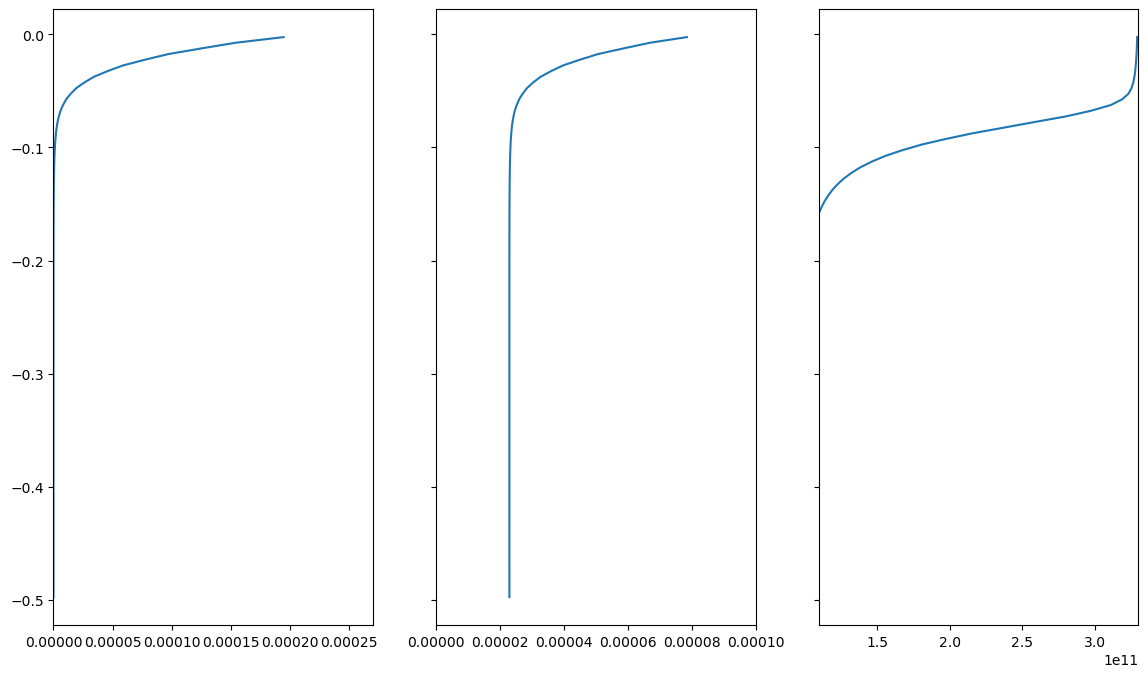

In [27]:
time_ind = -1
fig, axs = plt.subplots(1,3,figsize = (14,8), sharey = True)
axs[0].plot(res[time_ind,:,0],-np.arange(deltax/2,length,deltax))
axs[1].plot(res[time_ind,:,1],-np.arange(deltax/2,length,deltax))
axs[2].plot(res[time_ind,:,2],-np.arange(deltax/2,length,deltax))
axs[0].set_xlim([0,0.27e-3])
axs[1].set_xlim([0,.1e-3])
axs[2].set_xlim([1.1e11, 3.3e11]);

#### Plotting and comparing solutions:

Text(0, 0.5, '[O2] [$ mol/L$]')

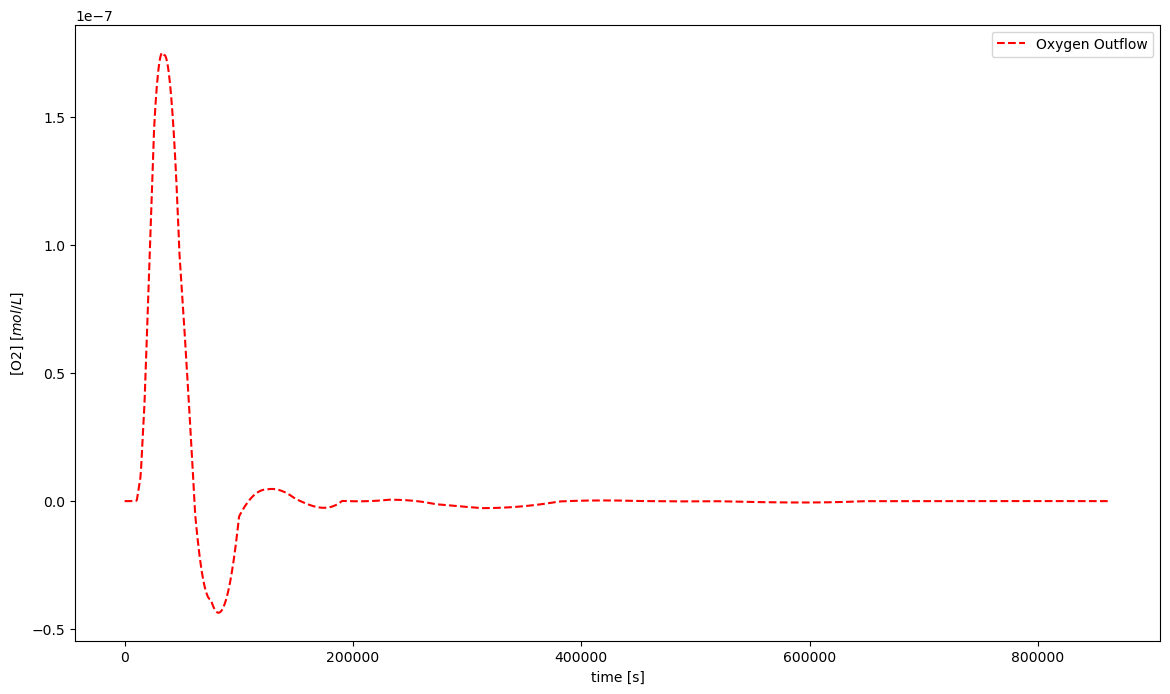

In [26]:
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)
ax.plot(time_intervals,res[:,-1,0], '--r', label = 'Oxygen Outflow')

#ax.set_xlim([0,6])
ax.legend()
ax.set_xlabel('time [s]')
ax.set_ylabel(r'[O2] [$ mol/L$]')